## Preparation

In [1]:
import pandas as pd
# import visualization  libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
taxi.duplicated().sum()

0

In [4]:
taxi.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
# convert datetime coulmn from object to datetime
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [7]:
# set datetime column as index
taxi.set_index('datetime', inplace=True)

In [8]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
# resample data by the hour
taxi = taxi.resample('1H').sum()

In [10]:
# the data seems sorted but just for good measure
taxi.sort_index(inplace=True)

In [11]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Analysis

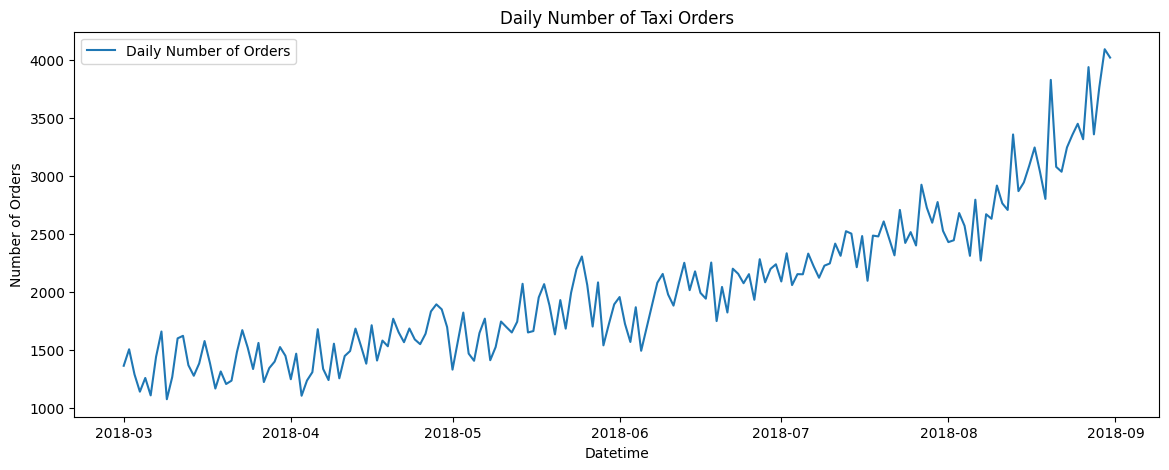

In [12]:
# resample by day
taxi_daily = taxi.resample('1D').sum()

plt.figure(figsize=(14, 5))
plt.plot(taxi_daily.index, taxi_daily['num_orders'], label='Daily Number of Orders')
plt.title('Daily Number of Taxi Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

General upward trend from March to August 2018
Significant daily fluctuations, likely due to day-of-week effects
Increasing amplitude of fluctuations over time
Growth from about 1,500 daily orders in March to peaks over 4,000 in August

In [13]:
taxi_eda = taxi_daily.copy()
taxi_eda['7-Day-SMA'] = taxi_eda['num_orders'].rolling(window=7).mean()

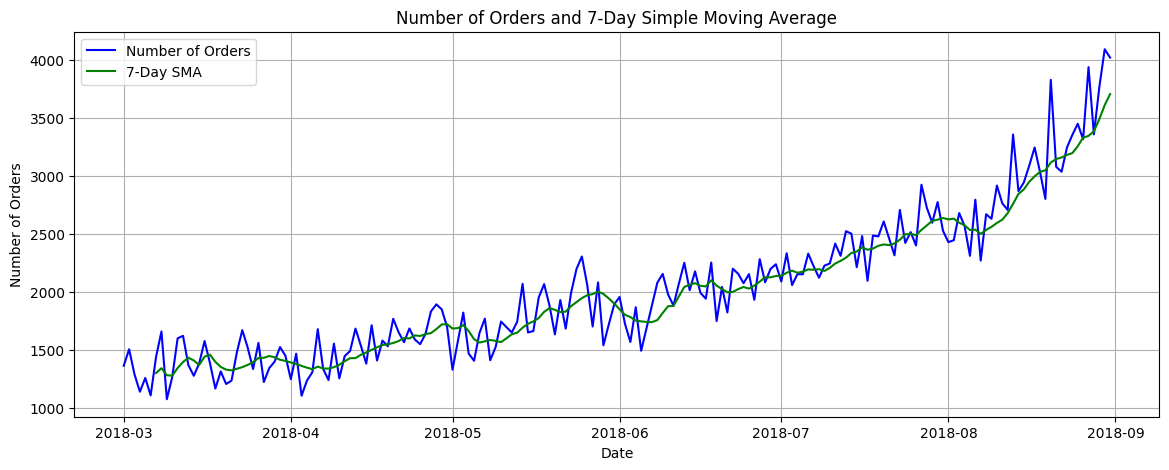

In [14]:
# Plotting the data
plt.figure(figsize=(14, 5))
plt.plot(taxi_eda['num_orders'], label='Number of Orders', color='blue')
plt.plot(taxi_eda['7-Day-SMA'], label='7-Day SMA', color='green')

# Adding title and labels
plt.title('Number of Orders and 7-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

The graph shows a clear upward trend in the number of orders from March to September 2018, with the daily order count increasing from around 1500 to 4000. There's significant daily volatility in orders, which the 7-Day Simple Moving Average smooths out to highlight the overall growth trend. The growth rate appears to accelerate in the latter half of the period, particularly from July onwards, with the highest peaks occurring in September.

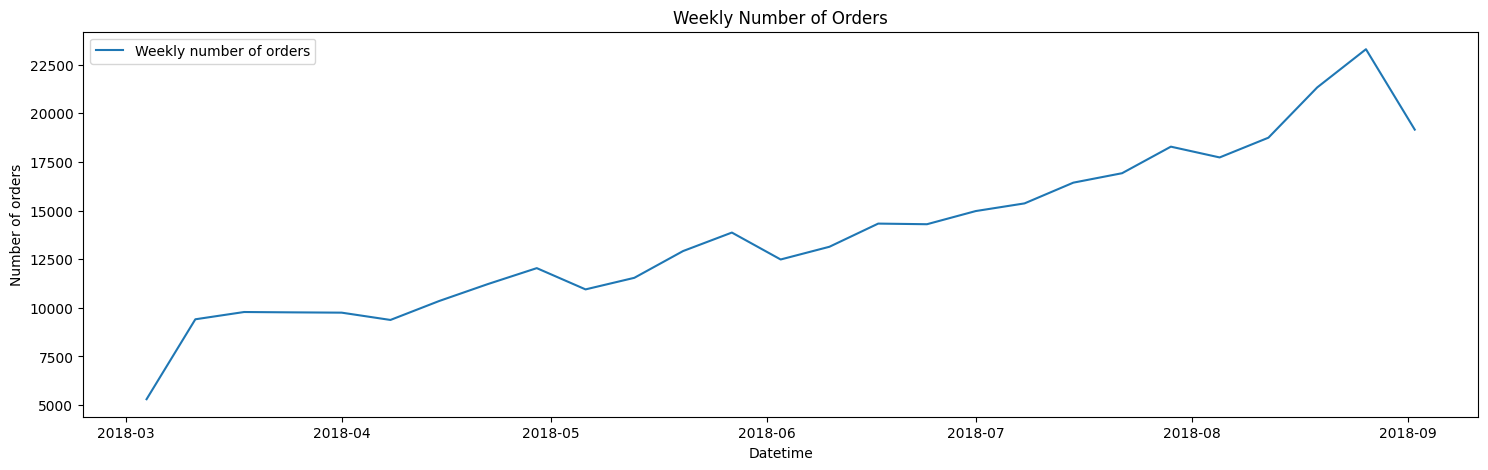

In [15]:
# resample by day
taxi_weekly = taxi.resample('1W').sum()

plt.figure(figsize=(18,5))
plt.plot(taxi_weekly.index, taxi_weekly['num_orders'], label='Weekly number of orders')
plt.title('Weekly Number of Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend()
plt.show()

In [16]:
# resample by weekly
taxi_weekly = taxi.resample('1W').sum()

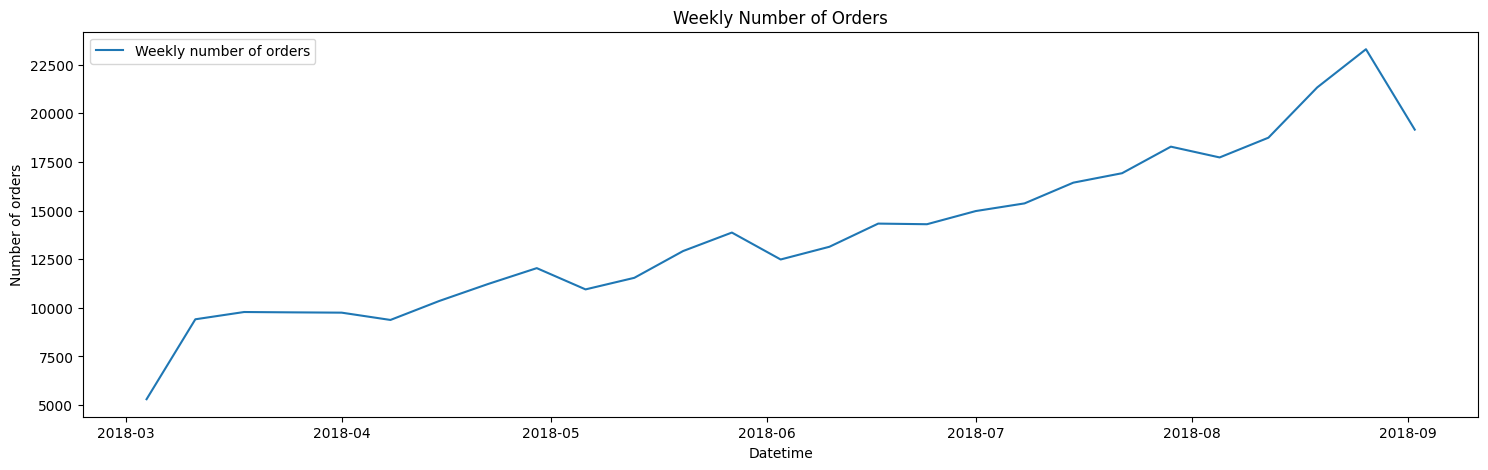

In [17]:
plt.figure(figsize=(18,5))
plt.plot(taxi_weekly.index, taxi_weekly['num_orders'], label='Weekly number of orders')
plt.title('Weekly Number of Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend()
plt.show()

Overall increasing trend from March to September 2018
Some week-to-week fluctuations, but generally consistent growth
Sharp increase in August, reaching peak of about 23,000 weekly orders
Slight decrease in the final week shown

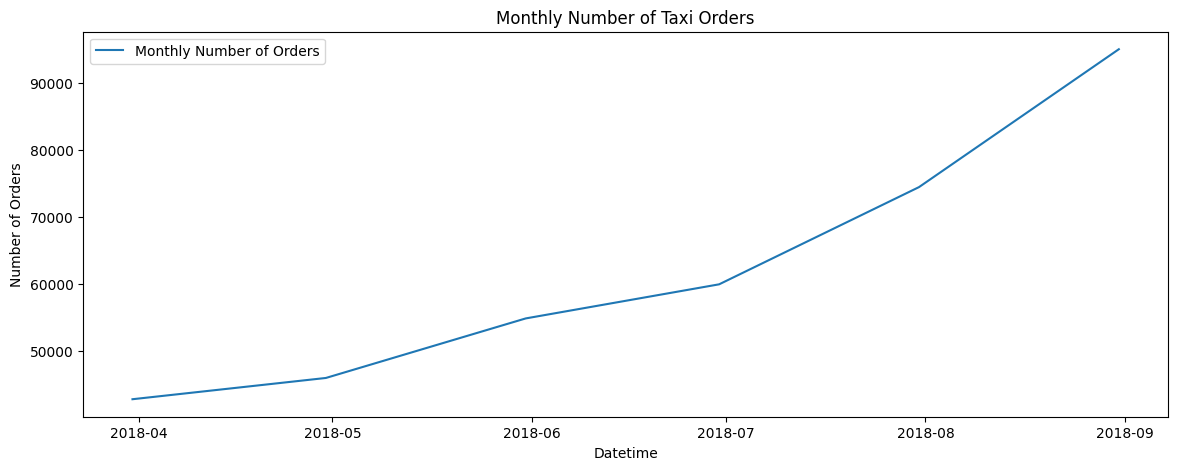

In [18]:
# Resample to monthly frequency
taxi_monthly = taxi.resample('M').sum()

plt.figure(figsize=(14, 5))
plt.plot(taxi_monthly.index, taxi_monthly['num_orders'], label='Monthly Number of Orders')
plt.title('Monthly Number of Taxi Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

Clear upward trend from April to September 2018
Growth accelerates in later months, showing exponential-like growth
Increases from about 45,000 orders in April to over 90,000 in September

In [19]:
# decompose the data
decomposed = seasonal_decompose(taxi['num_orders'])

In [20]:
# Define the start and end dates for the two-week interval
start_date = '2018-08-01'  
end_date = '2018-08-07'  

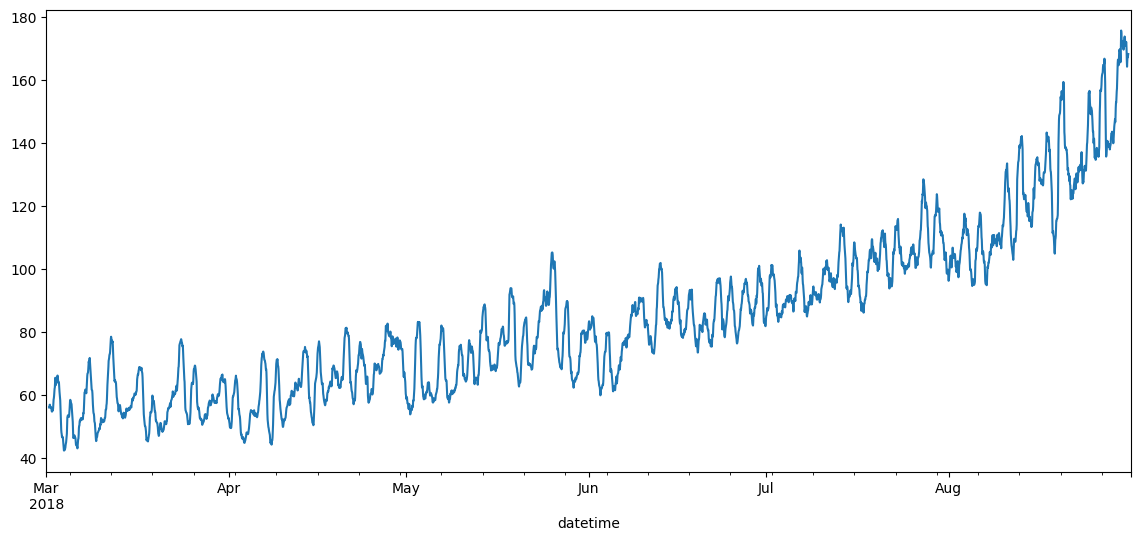

In [21]:
decomposed.trend.plot(figsize=(14,6));

Overall upward trend: The line shows a clear upward trajectory over the entire period, indicating a generally increasing trend in the underlying data.
Smooth progression: Unlike raw time series data, this trend line is relatively smooth, having removed seasonal and irregular fluctuations.

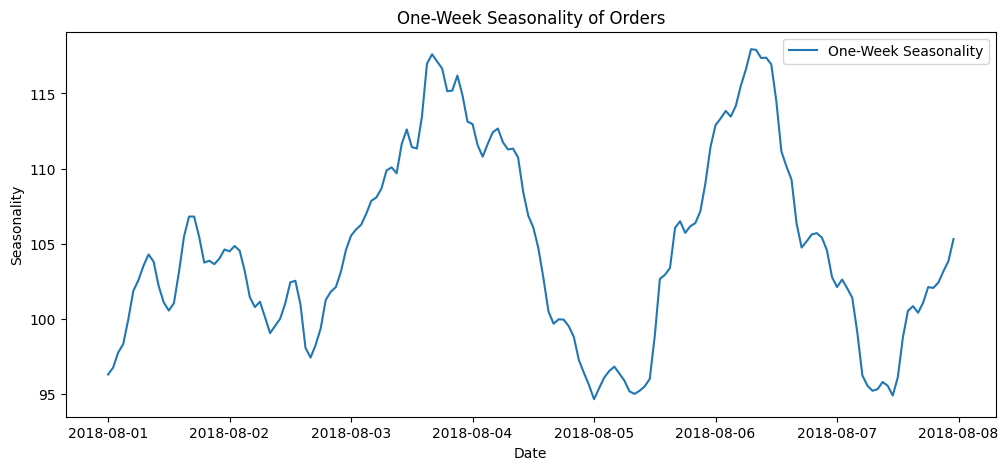

In [22]:
# Slice the seasonal component over the two-week interval
one_week_seasonality = decomposed.trend[start_date:end_date]

# Plot the seasonal component for the two-week interval
plt.figure(figsize=(12, 5))
plt.plot(one_week_seasonality, label='One-Week Seasonality')
plt.title('One-Week Seasonality of Orders')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.legend()
plt.show()

Over the course of one week, we see two peeks and dips throughout the week. There is a wave-like pattern with values ranging roughly between 95 and 120. There are several peaks and troughs over the week, with the highest peaks occurring around August 4th and August 6th around 120.

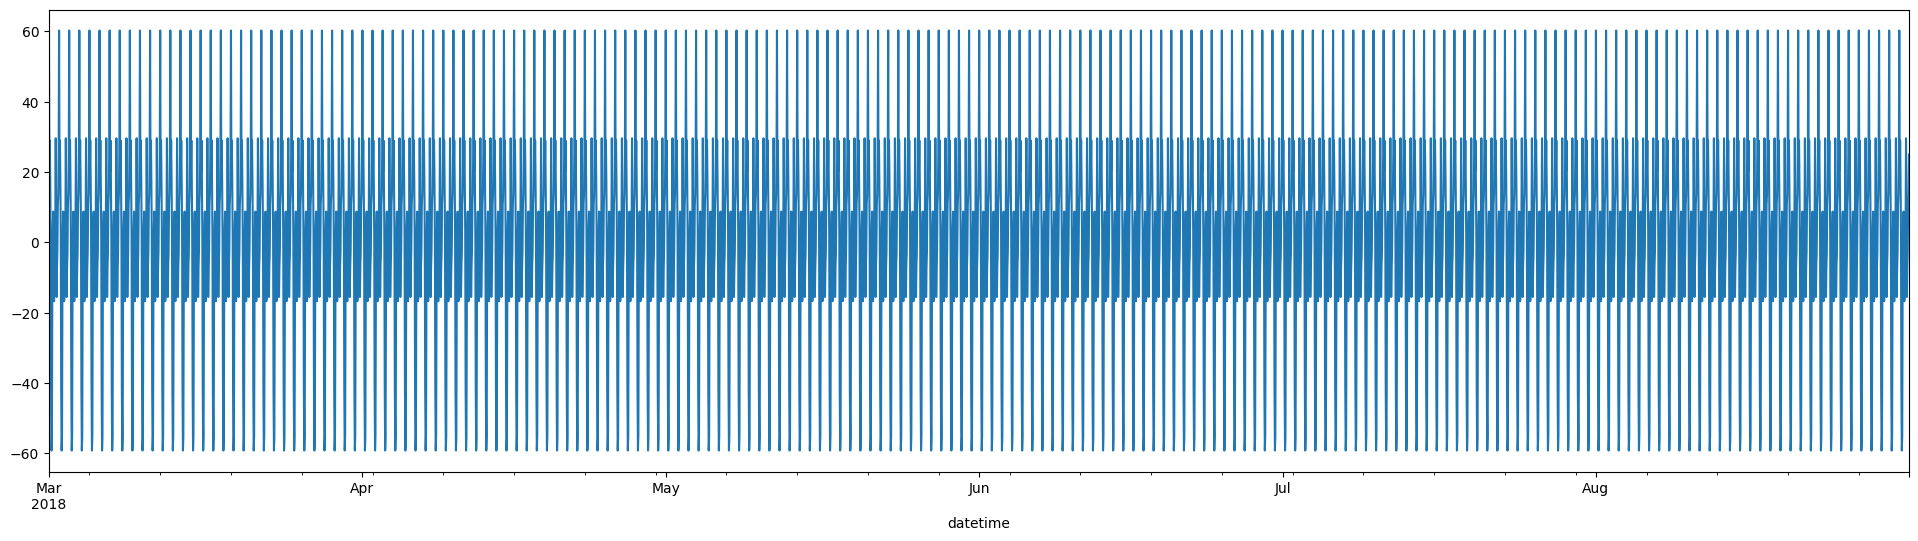

In [23]:
decomposed.seasonal.plot(figsize=(24,6));

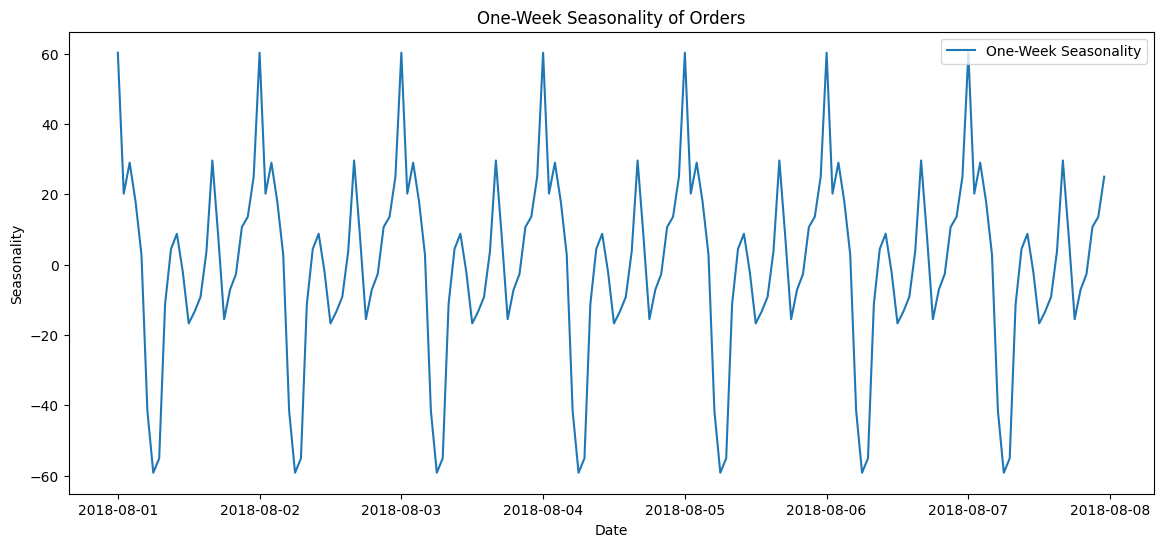

In [24]:
# Slice the seasonal component over the two-week interval
one_week_seasonality = decomposed.seasonal[start_date:end_date]

# Plot the seasonal component for the two-week interval
plt.figure(figsize=(14, 6))
plt.plot(one_week_seasonality, label='One-Week Seasonality')
plt.title('One-Week Seasonality of Orders')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.legend()
plt.show()

There are much more dramatic and repetitive pattern. It has sharp, regular spikes reaching up to about 60, followed by steep drops to around -60. This pattern repeats daily throughout the week.

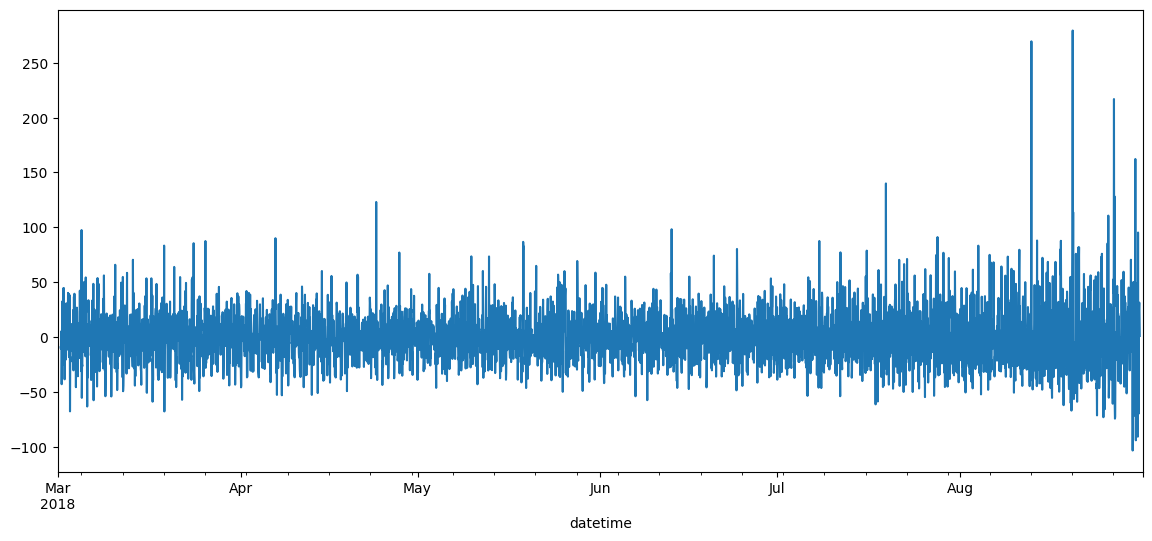

In [25]:
decomposed.resid.plot(figsize=(14,6));

In [26]:
def make_features(data, max_lag):
    # Create datetime features
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # For each lag from 1 to max_lag, it creates a new feature lag_{lag} which contains the value of num_orders shifted back by lag time steps.
    # This allows the model to use previous values of num_orders as features for prediction.
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Drop rows with missing values
    data.dropna(inplace=True)

In [27]:
# adding rolling mean
taxi['rolling_mean'] = taxi.shift(1).rolling(12).mean()

In [28]:
# make features
make_features(taxi, 12)

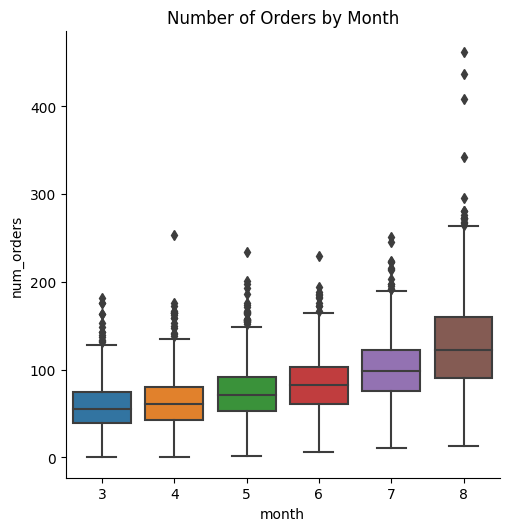

In [29]:
sns.catplot(x="month", y="num_orders", kind="box", data=taxi)
plt.title("Number of Orders by Month")
plt.show();

Shows a clear upward trend in number of orders from month 3 to month 8
Increasing median and variability (box size) each month
Presence of outliers, especially in later months
Highest median and maximum values in month 8

## Training

In [30]:
# feautures
features = taxi.drop(columns=['num_orders'])
target = taxi['num_orders']

# Perform train-test split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

In [31]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [32]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [100, 200]
}

# Initialize Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=12345)

# Setup GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid_rf, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_rf.fit(features_train, target_train)

# Print best parameters and RMSE
print("Best parameters found for Random Forest:")
print(grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_
predictions_rf = best_rf.predict(features_test)
rmse_rf = mean_squared_error(target_test, predictions_rf, squared=False)
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................max_depth=100, n_estimators=200; total time=   2.1s
[CV] END ....................max_depth=100, n_estimators=200; total time=   4.3s
[CV] END ....................max_depth=100, n_estimators=200; total time=   6.6s
[CV] END ....................max_depth=100, n_estimators=300; total time=   3.2s
[CV] END ....................max_depth=100, n_estimators=300; total time=   6.4s
[CV] END ....................max_depth=100, n_estimators=300; total time=   9.9s
[CV] END ....................max_depth=200, n_estimators=200; total time=   2.1s
[CV] END ....................max_depth=200, n_estimators=200; total time=   4.3s
[CV] END ....................max_depth=200, n_estimators=200; total time=   6.7s
[CV] END ....................max_depth=200, n_estimators=300; total time=   3.3s
[CV] END ....................max_depth=200, n_estimators=300; total time=   6.7s
[CV] END ....................max_depth=200, n_est

In [33]:
# Define the parameter grid
param_grid_lr = {
    'normalize': [True, False]
}

# Initialize Linear Regression
lr = LinearRegression()

# Setup GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_lr.fit(features_train, target_train)

# Print best parameters and RMSE on training set
print("Best parameters found for Linear Regression:")
print(grid_search_lr.best_params_)
best_lr = grid_search_lr.best_estimator_
train_predict_lr = best_lr.predict(features_train)
rmse_lr_train = mean_squared_error(target_train, train_predict_lr, squared=False)
print(f"Linear Regression RMSE on Training Set: {rmse_lr_train:.2f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
Best parameters found for Linear Regression:
{'normalize': True}
Linear Regression RMSE on Training Set: 30.09


In [34]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

# Initialize XGBoost Regressor
xgb_reg = XGBRegressor(random_state=12345)

# Setup GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_xgb.fit(features_train, target_train)

# Print best parameters and RMSE on training set
print("Best parameters found for XGBoost:")
print(grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_

# Calculate RMSE on training set
train_predict_xgb = best_xgb.predict(features_train)
rmse_xgb_train = mean_squared_error(target_train, train_predict_xgb, squared=False)
print(f"XGBoost RMSE on Training Set: {rmse_xgb_train:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   1.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   1.5s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   2.0s
[CV] END ...............learning_rate=0.05, n_estimators=200; total time=   2.3s
[CV] END ...............learning_rate=0.05, n_estimators=200; total time=   2.9s
[CV] END ...............learning_rate=0.05, n_estimators=200; total time=   3.6s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.6s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.4s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.8s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=   2.4s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=   2.9s
[CV] END ................learning_rate=0.1, n_est

In [35]:
# Define the parameter grid
param_grid_catboost = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'random_seed': [12345]
}

# Initialize CatBoost Regressor
catboost_reg = CatBoostRegressor()

# Setup GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost_reg, param_grid=param_grid_catboost, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_catboost.fit(features_train, target_train)

# Print best parameters and RMSE on training set
print("Best parameters found for CatBoost:")
print(grid_search_catboost.best_params_)
best_catboost = grid_search_catboost.best_estimator_

# Calculate RMSE on training set
train_predict_catboost = best_catboost.predict(features_train)
rmse_catboost_train = mean_squared_error(target_train, train_predict_catboost, squared=False)
print(f"CatBoost RMSE on Training Set: {rmse_catboost_train:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 28.7338800	total: 49.8ms	remaining: 4.93s
1:	learn: 28.1832297	total: 52.9ms	remaining: 2.59s
2:	learn: 27.5965731	total: 56.2ms	remaining: 1.82s
3:	learn: 27.0356184	total: 59.4ms	remaining: 1.43s
4:	learn: 26.5492984	total: 62.8ms	remaining: 1.19s
5:	learn: 26.0656854	total: 66.2ms	remaining: 1.04s
6:	learn: 25.6151834	total: 69.6ms	remaining: 924ms
7:	learn: 25.1848101	total: 73.5ms	remaining: 845ms
8:	learn: 24.7491314	total: 76.9ms	remaining: 778ms
9:	learn: 24.3986186	total: 80.2ms	remaining: 722ms
10:	learn: 24.1275741	total: 83.4ms	remaining: 675ms
11:	learn: 23.7669737	total: 86.8ms	remaining: 636ms
12:	learn: 23.4303666	total: 89.9ms	remaining: 602ms
13:	learn: 23.0892517	total: 93.3ms	remaining: 573ms
14:	learn: 22.7395579	total: 97.1ms	remaining: 550ms
15:	learn: 22.4393406	total: 101ms	remaining: 529ms
16:	learn: 22.2107320	total: 104ms	remaining: 507ms
17:	learn: 21.9853908	total: 107ms	remaining: 488ms

[CV] END iterations=100, learning_rate=0.05, random_seed=12345; total time=   0.5s
0:	learn: 33.2638739	total: 4.97ms	remaining: 492ms
1:	learn: 32.5706332	total: 9.7ms	remaining: 475ms
2:	learn: 31.8746554	total: 14.3ms	remaining: 464ms
3:	learn: 31.2347964	total: 19ms	remaining: 457ms
4:	learn: 30.6687355	total: 23.7ms	remaining: 450ms
5:	learn: 30.2215227	total: 28.2ms	remaining: 442ms
6:	learn: 29.6915108	total: 32.7ms	remaining: 434ms
7:	learn: 29.2090352	total: 37.3ms	remaining: 428ms
8:	learn: 28.7653390	total: 41.7ms	remaining: 422ms
9:	learn: 28.3819359	total: 46.4ms	remaining: 418ms
10:	learn: 28.0217443	total: 50.9ms	remaining: 412ms
11:	learn: 27.6401126	total: 55.5ms	remaining: 407ms
12:	learn: 27.3341442	total: 60ms	remaining: 402ms
13:	learn: 26.9650456	total: 64.4ms	remaining: 396ms
14:	learn: 26.6481569	total: 68.9ms	remaining: 390ms
15:	learn: 26.3469220	total: 73.4ms	remaining: 385ms
16:	learn: 26.1214622	total: 77.9ms	remaining: 380ms
17:	learn: 25.8486716	total: 82

61:	learn: 14.7716608	total: 204ms	remaining: 125ms
62:	learn: 14.6984379	total: 208ms	remaining: 122ms
63:	learn: 14.6538799	total: 211ms	remaining: 119ms
64:	learn: 14.6195874	total: 214ms	remaining: 115ms
65:	learn: 14.5312389	total: 217ms	remaining: 112ms
66:	learn: 14.4340636	total: 221ms	remaining: 109ms
67:	learn: 14.3973713	total: 224ms	remaining: 105ms
68:	learn: 14.3239636	total: 227ms	remaining: 102ms
69:	learn: 14.2518350	total: 230ms	remaining: 98.7ms
70:	learn: 14.1823279	total: 233ms	remaining: 95.3ms
71:	learn: 14.1379804	total: 237ms	remaining: 92ms
72:	learn: 14.0938614	total: 240ms	remaining: 88.7ms
73:	learn: 14.0568510	total: 247ms	remaining: 86.9ms
74:	learn: 13.9987482	total: 251ms	remaining: 83.5ms
75:	learn: 13.9256355	total: 254ms	remaining: 80.2ms
76:	learn: 13.8461352	total: 257ms	remaining: 76.9ms
77:	learn: 13.7801478	total: 261ms	remaining: 73.6ms
78:	learn: 13.7169630	total: 264ms	remaining: 70.2ms
79:	learn: 13.6235666	total: 267ms	remaining: 66.8ms
80:

19:	learn: 22.5350375	total: 97.9ms	remaining: 392ms
20:	learn: 22.2919250	total: 103ms	remaining: 388ms
21:	learn: 22.0462705	total: 108ms	remaining: 382ms
22:	learn: 21.8775897	total: 112ms	remaining: 377ms
23:	learn: 21.7170331	total: 117ms	remaining: 370ms
24:	learn: 21.5905651	total: 121ms	remaining: 364ms
25:	learn: 21.4263208	total: 126ms	remaining: 359ms
26:	learn: 21.2931401	total: 130ms	remaining: 353ms
27:	learn: 21.1774312	total: 135ms	remaining: 347ms
28:	learn: 21.0132730	total: 140ms	remaining: 342ms
29:	learn: 20.8734336	total: 144ms	remaining: 336ms
30:	learn: 20.8000724	total: 148ms	remaining: 330ms
31:	learn: 20.7273762	total: 153ms	remaining: 325ms
32:	learn: 20.6742181	total: 157ms	remaining: 319ms
33:	learn: 20.6065480	total: 162ms	remaining: 314ms
34:	learn: 20.5430548	total: 166ms	remaining: 308ms
35:	learn: 20.4839439	total: 170ms	remaining: 303ms
36:	learn: 20.4026968	total: 175ms	remaining: 298ms
37:	learn: 20.3295529	total: 180ms	remaining: 293ms
38:	learn: 

101:	learn: 15.3085697	total: 342ms	remaining: 329ms
102:	learn: 15.2716722	total: 346ms	remaining: 326ms
103:	learn: 15.2101097	total: 349ms	remaining: 322ms
104:	learn: 15.1750588	total: 352ms	remaining: 319ms
105:	learn: 15.1473905	total: 355ms	remaining: 315ms
106:	learn: 15.1158050	total: 359ms	remaining: 312ms
107:	learn: 15.0812817	total: 362ms	remaining: 308ms
108:	learn: 15.0348293	total: 365ms	remaining: 305ms
109:	learn: 15.0135003	total: 368ms	remaining: 301ms
110:	learn: 14.9711800	total: 371ms	remaining: 298ms
111:	learn: 14.9348440	total: 375ms	remaining: 294ms
112:	learn: 14.9032648	total: 378ms	remaining: 291ms
113:	learn: 14.8784587	total: 381ms	remaining: 288ms
114:	learn: 14.8475873	total: 385ms	remaining: 284ms
115:	learn: 14.8162459	total: 388ms	remaining: 281ms
116:	learn: 14.7872185	total: 391ms	remaining: 277ms
117:	learn: 14.7332094	total: 394ms	remaining: 274ms
118:	learn: 14.6976522	total: 397ms	remaining: 270ms
119:	learn: 14.6728156	total: 401ms	remaining:

101:	learn: 17.9586506	total: 408ms	remaining: 392ms
102:	learn: 17.9346890	total: 412ms	remaining: 388ms
103:	learn: 17.9113414	total: 416ms	remaining: 384ms
104:	learn: 17.8889693	total: 420ms	remaining: 380ms
105:	learn: 17.8664896	total: 423ms	remaining: 375ms
106:	learn: 17.8305011	total: 427ms	remaining: 371ms
107:	learn: 17.7966530	total: 431ms	remaining: 367ms
108:	learn: 17.7777448	total: 435ms	remaining: 363ms
109:	learn: 17.7531235	total: 439ms	remaining: 360ms
110:	learn: 17.7354762	total: 444ms	remaining: 356ms
111:	learn: 17.7058923	total: 448ms	remaining: 352ms
112:	learn: 17.6803727	total: 452ms	remaining: 348ms
113:	learn: 17.6611976	total: 456ms	remaining: 344ms
114:	learn: 17.6496219	total: 460ms	remaining: 340ms
115:	learn: 17.6199857	total: 464ms	remaining: 336ms
116:	learn: 17.5770945	total: 467ms	remaining: 332ms
117:	learn: 17.5517987	total: 471ms	remaining: 327ms
118:	learn: 17.5249779	total: 475ms	remaining: 323ms
119:	learn: 17.4904207	total: 479ms	remaining:

64:	learn: 20.8003297	total: 296ms	remaining: 615ms
65:	learn: 20.7373082	total: 301ms	remaining: 610ms
66:	learn: 20.6944744	total: 305ms	remaining: 606ms
67:	learn: 20.6604897	total: 310ms	remaining: 601ms
68:	learn: 20.6308637	total: 314ms	remaining: 596ms
69:	learn: 20.5866789	total: 318ms	remaining: 591ms
70:	learn: 20.5450638	total: 323ms	remaining: 586ms
71:	learn: 20.5159901	total: 327ms	remaining: 581ms
72:	learn: 20.4699197	total: 331ms	remaining: 576ms
73:	learn: 20.4443498	total: 336ms	remaining: 572ms
74:	learn: 20.4087717	total: 340ms	remaining: 567ms
75:	learn: 20.3654585	total: 345ms	remaining: 563ms
76:	learn: 20.3410948	total: 349ms	remaining: 558ms
77:	learn: 20.3126179	total: 354ms	remaining: 553ms
78:	learn: 20.2679605	total: 358ms	remaining: 548ms
79:	learn: 20.2380473	total: 362ms	remaining: 543ms
80:	learn: 20.2136907	total: 367ms	remaining: 539ms
81:	learn: 20.1724704	total: 371ms	remaining: 534ms
82:	learn: 20.1205174	total: 380ms	remaining: 535ms
83:	learn: 2

24:	learn: 17.8565010	total: 85.9ms	remaining: 601ms
25:	learn: 17.7374877	total: 89.9ms	remaining: 602ms
26:	learn: 17.6117317	total: 93.3ms	remaining: 598ms
27:	learn: 17.4801107	total: 96.7ms	remaining: 594ms
28:	learn: 17.3044284	total: 100ms	remaining: 592ms
29:	learn: 17.1538653	total: 104ms	remaining: 590ms
30:	learn: 17.0494255	total: 108ms	remaining: 587ms
31:	learn: 16.9705053	total: 111ms	remaining: 584ms
32:	learn: 16.9113730	total: 115ms	remaining: 582ms
33:	learn: 16.7877044	total: 119ms	remaining: 580ms
34:	learn: 16.7248721	total: 122ms	remaining: 577ms
35:	learn: 16.6502222	total: 126ms	remaining: 575ms
36:	learn: 16.5805108	total: 130ms	remaining: 573ms
37:	learn: 16.4592430	total: 133ms	remaining: 568ms
38:	learn: 16.3602310	total: 137ms	remaining: 564ms
39:	learn: 16.2803418	total: 140ms	remaining: 560ms
40:	learn: 16.1798189	total: 143ms	remaining: 555ms
41:	learn: 16.0973486	total: 147ms	remaining: 551ms
42:	learn: 16.0075110	total: 150ms	remaining: 547ms
43:	lear

[CV] END iterations=200, learning_rate=0.1, random_seed=12345; total time=   0.8s
0:	learn: 30.5746232	total: 4.3ms	remaining: 855ms
1:	learn: 29.3792119	total: 8.46ms	remaining: 837ms
2:	learn: 28.4990824	total: 12.6ms	remaining: 825ms
3:	learn: 27.5030030	total: 16.6ms	remaining: 815ms
4:	learn: 26.8351409	total: 20.6ms	remaining: 805ms
5:	learn: 26.2690143	total: 24.7ms	remaining: 800ms
6:	learn: 25.5453900	total: 28.6ms	remaining: 789ms
7:	learn: 24.9252737	total: 32.5ms	remaining: 780ms
8:	learn: 24.3662535	total: 36.6ms	remaining: 776ms
9:	learn: 23.9326375	total: 40.7ms	remaining: 773ms
10:	learn: 23.5170150	total: 44.7ms	remaining: 768ms
11:	learn: 23.1257313	total: 48.8ms	remaining: 764ms
12:	learn: 22.8340785	total: 52.7ms	remaining: 758ms
13:	learn: 22.4446855	total: 56.8ms	remaining: 755ms
14:	learn: 22.1395488	total: 60.7ms	remaining: 749ms
15:	learn: 21.8552817	total: 64.8ms	remaining: 746ms
16:	learn: 21.6303028	total: 68.7ms	remaining: 740ms
17:	learn: 21.4067079	total:

184:	learn: 12.6435556	total: 747ms	remaining: 60.6ms
185:	learn: 12.6028996	total: 751ms	remaining: 56.6ms
186:	learn: 12.5931684	total: 756ms	remaining: 52.5ms
187:	learn: 12.5620860	total: 759ms	remaining: 48.5ms
188:	learn: 12.5359913	total: 763ms	remaining: 44.4ms
189:	learn: 12.5066761	total: 767ms	remaining: 40.4ms
190:	learn: 12.4700235	total: 771ms	remaining: 36.3ms
191:	learn: 12.4500057	total: 775ms	remaining: 32.3ms
192:	learn: 12.4321467	total: 779ms	remaining: 28.3ms
193:	learn: 12.4308932	total: 783ms	remaining: 24.2ms
194:	learn: 12.4075361	total: 787ms	remaining: 20.2ms
195:	learn: 12.3639466	total: 791ms	remaining: 16.1ms
196:	learn: 12.3266261	total: 795ms	remaining: 12.1ms
197:	learn: 12.3254052	total: 799ms	remaining: 8.07ms
198:	learn: 12.2960837	total: 803ms	remaining: 4.04ms
199:	learn: 12.2701542	total: 807ms	remaining: 0us
[CV] END iterations=200, learning_rate=0.1, random_seed=12345; total time=   0.9s
0:	learn: 32.6273599	total: 4.66ms	remaining: 927ms
1:	le

181:	learn: 14.8856835	total: 837ms	remaining: 82.8ms
182:	learn: 14.8643049	total: 842ms	remaining: 78.2ms
183:	learn: 14.8195249	total: 847ms	remaining: 73.6ms
184:	learn: 14.8152910	total: 851ms	remaining: 69ms
185:	learn: 14.8017253	total: 855ms	remaining: 64.4ms
186:	learn: 14.7861719	total: 860ms	remaining: 59.8ms
187:	learn: 14.7722742	total: 864ms	remaining: 55.1ms
188:	learn: 14.7504842	total: 868ms	remaining: 50.5ms
189:	learn: 14.7363582	total: 873ms	remaining: 45.9ms
190:	learn: 14.7350763	total: 877ms	remaining: 41.3ms
191:	learn: 14.7021885	total: 881ms	remaining: 36.7ms
192:	learn: 14.6700634	total: 885ms	remaining: 32.1ms
193:	learn: 14.6456379	total: 890ms	remaining: 27.5ms
194:	learn: 14.6292490	total: 894ms	remaining: 22.9ms
195:	learn: 14.6102046	total: 899ms	remaining: 18.3ms
196:	learn: 14.5983487	total: 903ms	remaining: 13.8ms
197:	learn: 14.5879786	total: 908ms	remaining: 9.17ms
198:	learn: 14.5487444	total: 912ms	remaining: 4.58ms
199:	learn: 14.5120562	total: 

149:	learn: 17.9932170	total: 815ms	remaining: 272ms
150:	learn: 17.9522650	total: 821ms	remaining: 266ms
151:	learn: 17.9104595	total: 826ms	remaining: 261ms
152:	learn: 17.8949490	total: 831ms	remaining: 255ms
153:	learn: 17.8705748	total: 837ms	remaining: 250ms
154:	learn: 17.8403563	total: 842ms	remaining: 244ms
155:	learn: 17.8163673	total: 847ms	remaining: 239ms
156:	learn: 17.8125167	total: 851ms	remaining: 233ms
157:	learn: 17.7770784	total: 856ms	remaining: 228ms
158:	learn: 17.7546515	total: 862ms	remaining: 222ms
159:	learn: 17.7325542	total: 867ms	remaining: 217ms
160:	learn: 17.7104006	total: 872ms	remaining: 211ms
161:	learn: 17.7009309	total: 877ms	remaining: 206ms
162:	learn: 17.6727547	total: 883ms	remaining: 200ms
163:	learn: 17.6414040	total: 892ms	remaining: 196ms
164:	learn: 17.6171266	total: 897ms	remaining: 190ms
165:	learn: 17.5832382	total: 902ms	remaining: 185ms
166:	learn: 17.5609299	total: 907ms	remaining: 179ms
167:	learn: 17.5454296	total: 912ms	remaining:

## Testing

In [36]:
# Initialize Random Forest with best parameters
best_rf = RandomForestRegressor(max_depth=100, n_estimators=300, random_state=12345)

# Fit on the training data
best_rf.fit(features_train, target_train)

# Predict on the test set
predictions_rf = best_rf.predict(features_test)

# Calculate RMSE on test set
rmse_rf_test = mean_squared_error(target_test, predictions_rf, squared=False)
print(f"Random Forest RMSE on Test Set: {rmse_rf_test:.2f}")

Random Forest RMSE on Test Set: 43.17


In [37]:
# Initialize Linear Regression with best parameters
best_lr = LinearRegression(normalize=True)

# Fit on the training data
best_lr.fit(features_train, target_train)

# Predict on the test set
predictions_lr = best_lr.predict(features_test)

# Calculate RMSE on test set
rmse_lr_test = mean_squared_error(target_test, predictions_lr, squared=False)
print(f"Linear Regression RMSE on Test Set: {rmse_lr_test:.2f}")

Linear Regression RMSE on Test Set: 52.51


In [38]:
# Initialize XGBoost Regressor with best parameters
best_xgb = XGBRegressor(learning_rate=0.05, n_estimators=200, random_state=12345)

# Fit on the training data
best_xgb.fit(features_train, target_train)

# Predict on the test set
predictions_xgb = best_xgb.predict(features_test)

# Calculate RMSE on test set
rmse_xgb_test = mean_squared_error(target_test, predictions_xgb, squared=False)
print(f"XGBoost RMSE on Test Set: {rmse_xgb_test:.2f}")

XGBoost RMSE on Test Set: 43.29


In [39]:
# Initialize CatBoost Regressor with best parameters
best_catboost = CatBoostRegressor(iterations=200, learning_rate=0.1, random_seed=12345)

# Fit on the training data
best_catboost.fit(features_train, target_train)

# Predict on the test set
predictions_catboost = best_catboost.predict(features_test)

# Calculate RMSE on test set
rmse_catboost_test = mean_squared_error(target_test, predictions_catboost, squared=False)
print(f"CatBoost RMSE on Test Set: {rmse_catboost_test:.2f}")

0:	learn: 36.9225288	total: 5.82ms	remaining: 1.16s
1:	learn: 35.4000053	total: 11.5ms	remaining: 1.14s
2:	learn: 33.9671182	total: 17ms	remaining: 1.11s
3:	learn: 32.7128618	total: 22.4ms	remaining: 1.1s
4:	learn: 31.6540181	total: 27.7ms	remaining: 1.08s
5:	learn: 30.6704506	total: 33ms	remaining: 1.07s
6:	learn: 29.9344962	total: 38.3ms	remaining: 1.05s
7:	learn: 29.4535408	total: 43.9ms	remaining: 1.05s
8:	learn: 28.9026555	total: 49.8ms	remaining: 1.06s
9:	learn: 28.2287037	total: 55.3ms	remaining: 1.05s
10:	learn: 27.7408367	total: 60.8ms	remaining: 1.04s
11:	learn: 27.1745700	total: 66ms	remaining: 1.03s
12:	learn: 26.8179035	total: 71.2ms	remaining: 1.02s
13:	learn: 26.3312071	total: 76.6ms	remaining: 1.02s
14:	learn: 25.9626298	total: 82ms	remaining: 1.01s
15:	learn: 25.6298291	total: 87.1ms	remaining: 1s
16:	learn: 25.3640336	total: 92.4ms	remaining: 995ms
17:	learn: 25.1350032	total: 97.7ms	remaining: 988ms
18:	learn: 24.8980463	total: 103ms	remaining: 980ms
19:	learn: 24.67

171:	learn: 17.4600714	total: 934ms	remaining: 152ms
172:	learn: 17.4532176	total: 939ms	remaining: 147ms
173:	learn: 17.4079327	total: 945ms	remaining: 141ms
174:	learn: 17.3891706	total: 950ms	remaining: 136ms
175:	learn: 17.3697526	total: 956ms	remaining: 130ms
176:	learn: 17.3514743	total: 961ms	remaining: 125ms
177:	learn: 17.3471334	total: 966ms	remaining: 119ms
178:	learn: 17.3324026	total: 971ms	remaining: 114ms
179:	learn: 17.2895195	total: 977ms	remaining: 109ms
180:	learn: 17.2757064	total: 982ms	remaining: 103ms
181:	learn: 17.2630722	total: 987ms	remaining: 97.6ms
182:	learn: 17.2329951	total: 993ms	remaining: 92.2ms
183:	learn: 17.2130935	total: 998ms	remaining: 86.8ms
184:	learn: 17.1987739	total: 1s	remaining: 81.3ms
185:	learn: 17.1591823	total: 1.01s	remaining: 75.9ms
186:	learn: 17.1251977	total: 1.02s	remaining: 70.7ms
187:	learn: 17.0843194	total: 1.02s	remaining: 65.3ms
188:	learn: 17.0822577	total: 1.03s	remaining: 59.9ms
189:	learn: 17.0425793	total: 1.03s	remai

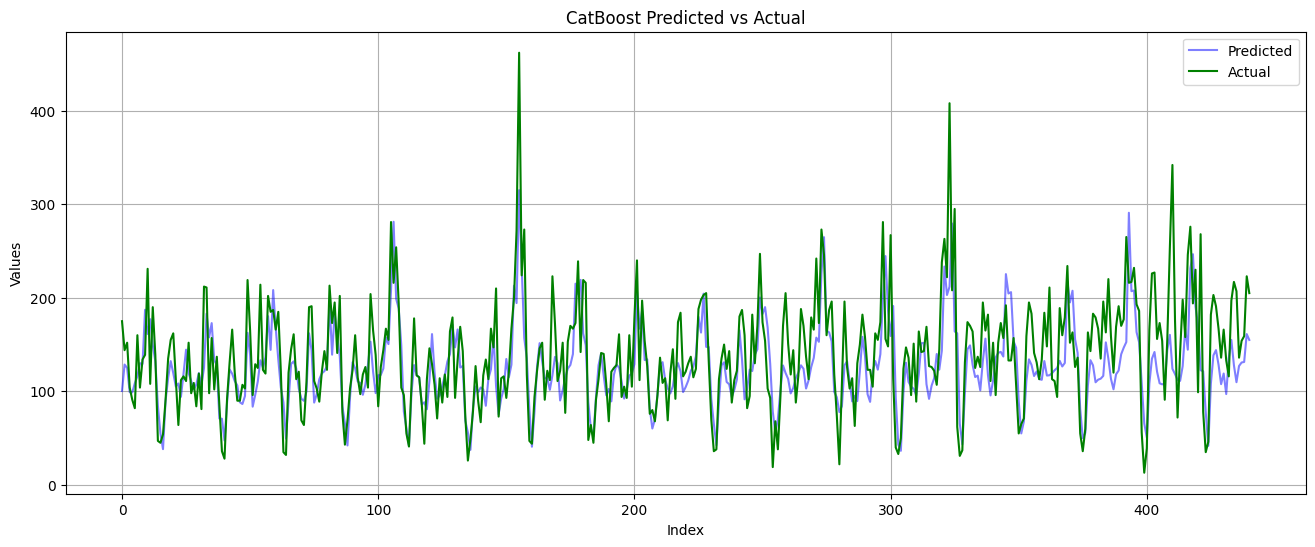

In [40]:
# Plotting predicted vs actual as line graphs
plt.figure(figsize=(16, 6))
plt.plot(predictions_catboost, label='Predicted', color='blue', alpha=0.50)
plt.plot(target_test.values, label='Actual', color='green')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('CatBoost Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion


### Daily and Weekly Trends:
- **Daily Orders**: There is a general upward trend in daily orders from March to August 2018, accompanied by significant daily fluctuations. These fluctuations likely stem from day-of-week effects, contributing to varying order volumes throughout the week. Daily orders grow notably from approximately 1,500 in March to peaks exceeding 4,000 in August.
  
- **Weekly Orders**: The weekly order data shows a consistent upward trend from March to September 2018, despite some week-to-week variations. Notably, there is a sharp increase in August, reaching a peak of about 23,000 weekly orders. Towards the end of the observed period, there is a slight decrease in weekly orders.

### Monthly Trends:
- **Monthly Orders**: Analyzing monthly data reveals a clear upward trajectory from April to September 2018. The growth accelerates in later months, demonstrating exponential-like growth. Orders increase substantially from around 45,000 in April to over 90,000 in September, reflecting a robust expansion of the service demand over the months.

### Decomposed Trend:
- **Overall Trend**: The decomposed trend analysis confirms an overall upward trend throughout the period, reflecting consistent growth in taxi orders. This trend line appears smooth compared to the raw data, as seasonal and irregular fluctuations have been filtered out, emphasizing the underlying upward progression.

### Box Plot Analysis:
- **Box Plot Insights**: The box plot visualization illustrates a clear upward trend in the number of orders from March (month 3) to August (month 8). Each subsequent month shows an increase in both the median and variability (box size) of order volumes. The presence of outliers, particularly in later months, indicates periods of exceptionally high order volumes. The highest median and maximum values are observed in August (month 8), highlighting the peak demand during this period.

### Model Performance (RMSE on Test Set):
- **Random Forest**: RMSE = 43.17
- **Linear Regression**: RMSE = 52.51
- **XGBoost**: RMSE = 43.29
- **CatBoost**: RMSE = 42.83


The analysis reveals a robust upward trend in taxi orders across daily, weekly, and monthly perspectives from March to August 2018. The service experiences significant growth, particularly evident in later months, with August standing out as a peak period for order volumes. The employed machine learning models, Random Forest, Linear Regression, XGBoost, and CatBoost, demonstrate varying levels of performance in predicting taxi orders, with CatBoost showing the lowest RMSE on the test set, indicating its effectiveness in forecasting demand.